# FWI Example with wavefield separation
This notebook explores performing up/down wavefield separation on source and receiver wavefields prior to correlation for a transmission experiment. We use a simple Kz wavenumber filter, zeroing negative or positive spatial frequencies in depth `z`. We then correlate source up with receiver up, and source down with receiver down.

We will contrast the wavefield separation FWI operator with the standard FWI operator. 

We will peform FWI using the following steps:
1. Prepare models
2. Build a small local compute cluster (2 workers) 
3. Create list of shot locations 
4. Build `F`, the distributed block operator for seismic modeling
5. Use `F` to create data for both models
6. Visualize data
7. Assess if data is cycle skipped at the farthest offsets
8. Build the `gradient!` and `cost` functions
9. Perform the FWI using `Optim.jl`
10. Visualize velocity models and objection function
11. Visualize data match 
12. Write models to local disk
13. Remove local files and workers

#### Note on runtime
Warning: this notebook takes more than 1 hour to run for 12 shots with two workers on an Intel 8168.

`lscpu` CPU information: `Intel(R) Xeon(R) Platinum 8168 CPU @ 2.70GHz`

## Add required packages
Uncomment the line below if you need to add these packages to your environment

In [1]:
# ]add Optim LineSearches

## Record time for start of notebook

In [2]:
time_beg = time()

1.603247037072161e9

In [3]:
using PyPlot, Distributed, Jets, JetPack, JetPackDSP, Printf

## 1. Prepare models
* Initial model is a wholespace
* True model is the initial model with a rectangular inclusion

In [4]:
dz,dx = 25,25
nz,nx = 251,251

v1 = 1500 .* ones(Float32,nz,nx);
v2 = 1500 .* ones(Float32,nz,nx);

w = 20
v1[div(nz,2)-w:div(nz,2)+w,div(nx,2)-w:div(nx,2)+w] .+= 100;

#### Visualize

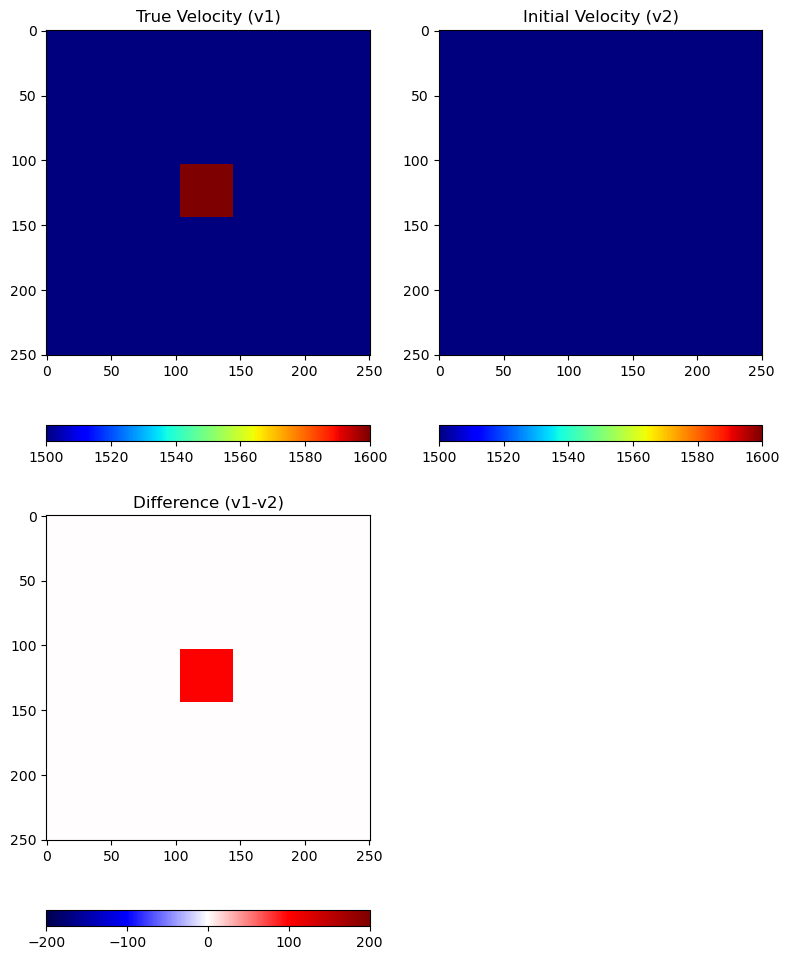

In [5]:
figure(figsize=(8,10))
vmin,vmax = extrema(v1)
dmin,dmax = -200,200

subplot(2,2,1); imshow(v1,aspect="auto",cmap="jet", interpolation="nearest"); 
colorbar(orientation="horizontal"); clim(vmin,vmax); title("True Velocity (v1)")

subplot(2,2,2); imshow(v2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax); title("Initial Velocity (v2)");

subplot(2,2,3); imshow(v1.-v2,aspect="auto",cmap="seismic", interpolation="nearest");
colorbar(orientation="horizontal"); clim(dmin,dmax); title("Difference (v1-v2)");

tight_layout()

## 2. Build a small local compute cluster (2 workers) 

#### Setup OMP environment variables for the cluster

In the distributed compute case the workers that we add would be on different hardware, and we might add tens of workers in 2D and hundreds in 3D. Here we run on a single machine with only 2 workers, and so we need to be careful with details related to high performance computing. If we did not specify thread affinity, the two workers would compete for the same physical cores and the modeling would be *incredibly* slow.

We spin up the small 2-worker cluster by calling `addprocs(2)`, and because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"` we will see the OMP environment printed out on each worker. In that output (below) we can verify that half of the total threads (44/2 = 22) are assigned to each socket on this 2 socket system. You can obtain more details about the hardware with the shell command `lscpu`.

We set four environment variables related to OpenMP:
* `OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker
* `OMP_PROC_BIND` specifies that threads should be bound to physical cores
* `OMP_NUM_THREADS` specifies the number of threads per workers is 1/2 the number of physical cores
* `GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker

If you run the shell command `top` during execution, you will see 3 julia processes: the main process and two workers. The two workers should generally have about 50% of the system, and `load average` should tend towards the physical number of cores.

In [6]:
nthread = Sys.CPU_THREADS
ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread,2))" 
addprocs(2)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, nthread
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

workers() = [2, 3]
(place1, place2, nthread) = (0, 21, 44)
(place1, place2, nthread) = (22, 43, 44)


In [7]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random

      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 3:	  _OPENMP = '201511'
      From worker 3:	  OMP_DYNAMIC = 'FALSE'
      From worker 3:	  OMP_NESTED = 'FALSE'
      From worker 3:	  OMP_NUM_THREADS = '22'
      From worker 3:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 3:	  OMP_PROC_BIND = 'CLOSE'
      From worker 3:	  OMP_PLACES = '{22},{23},{24},{25},{26},{27},{28},{29},{30},{31},{32},{33},{34},{35},{36},{37},{38},{39},{40},{41},{42},{43}'
      From worker 3:	  OMP_STACKSIZE = '0'
      From worker 3:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 3:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 3:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 3:	  OMP_CANCELLATION = 'FALSE'
      From worker 3:	  OMP_DEFAULT_DEVICE = '0'
      From worker 3:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 3:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 3:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From wor

## 3. Create list of shot locations 
We use 12 shot locations evenly in depth along the left edge of the model.

In [8]:
nshots = 12
sz = round.(Int,collect(range(0,stop=(nz-1)*dz,length=nshots)))
@show nshots;
@show sz;

nshots = 12
sz = [0, 568, 1136, 1705, 2273, 2841, 3409, 3977, 4545, 5114, 5682, 6250]


## 4. Build `F1` and `F2`, the distributed block operators for seismic modeling
* `F1` is the standard operator
* `F2` is the operator with wavefield separation via Kz wavenumber filter

#### Note on scratch space for temporary files
When dealing with serialized nonlinear wavefields as in this example, we need to specify the location where scratch files will be written.

You may need to change this to point to a temporary directory available on your system.

In [9]:
@everywhere scratch = "/mnt/scratch"
@assert isdir(scratch)

In [10]:
@everywhere begin
    ntrec = 3001
    dtrec = 0.004
    dtmod = 0.002
end

@everywhere function makeF(i,nz,nx,dz,dx,sz; imgcondition="standard")
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = ntrec,
        dtrec = dtrec,
        dtmod = dtmod,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=4.0),
        sz = sz[i],
        sx = dx,
        rz = dz * [0:1:nz-1;],
        rx = dx * (nx - 1) .* ones(nz),
        nbz_cache = nz,
        nbx_cache = 16,
        comptype = UInt32,
        nsponge = 100,
        imgcondition = imgcondition,
        srcfieldfile = joinpath(scratch, "field-$i-$(randstring()).bin"),
        reportinterval=0)
end

In [11]:
F1 = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sz,imgcondition="standard") 
        for i in I[1], j in I[2]], (nshots,1))

F2 = @blockop DArray(I->[makeF(i,nz,nx,dz,dx,sz,imgcondition="wavefieldseperation") 
        for i in I[1], j in I[2]], (nshots,1))

"Jet nonlinear operator, (251, 251) → (9039012,)"

## 5. Use `F1` to create the data in both models

In [12]:
t1 = @elapsed begin
    d1 = F1*v1;
end
@info @sprintf("Time in true model; %.2f seconds\n", t1);

t2 = @elapsed begin
    d2 = F1*v2;
end
@info @sprintf("Time in init model; %.2f seconds\n", t2);

┌ Info: Time in true model; 36.95 seconds
└ @ Main In[12]:4
┌ Info: Time in init model; 30.61 seconds
└ @ Main In[12]:9


#### Compute the residual data

In [13]:
r = d1 .- d2;

## 6. Visualize data

#### Collect 3 shots locally before plotting

In [14]:
shots = [1,6,12]
szlocal = [sz[i] for i in shots]
@show shots
@show szlocal;

d1local = [getblock(d1,i) for i in shots];
d2local = [getblock(d2,i) for i in shots];
r2local = [getblock(r,i) for i in shots];

shots = [1, 6, 12]
szlocal = [0, 2841, 6250]


#### Plot shot gathers for true model, initial model, and residual

The table below describes the data images below.

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Data</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual Data</b></td>
</tr>
</table>

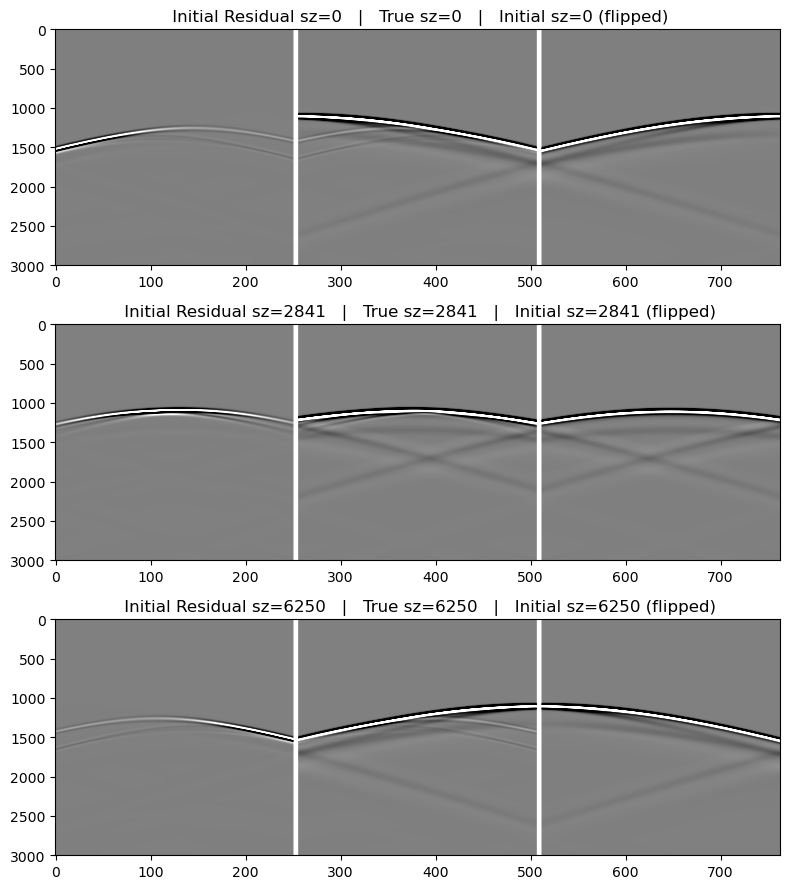

scale = 21.010731277246162


In [15]:
scale = 10.0 / sqrt(norm(d1)^2 / length(d1))
@show scale

nzero = 5
pad = ones(Float32,ntrec,nzero)

figure(figsize=(8,9)); clf()
for (iplot,ishot) in enumerate(shots)
    cat2 = hcat(d1local[iplot], pad, d2local[iplot], pad, r2local[iplot])
    subplot(3,1,iplot);
    imshow(cat2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title(" True sx=$(sx[ishot])   |   Initial sx=$(sx[ishot])   |   Initial Residual sx=$(sx[ishot])");
end
tight_layout()

## 8. Build the `gradient!` and `cost` functions

#### Build the `gradient!` function
This method is called by the solver whenever the gradient is required. Note one difference for this transmission experiment relative the first FWI notebook is that we do not want to apply source side illumination compensation.

Steps in computing the gradient are as follows:
1. Apply box constraints to keep velocity inside `[vmin,vmax]`
1. Apply the adjoint of the Jacobian to the current residual `J' * [F*v - d]` 
1. Apply simple scaling based on the size of the first gradient, and save to apply to future gradients

We can use this function for both operators `F1` and `F2`, but we need to be careful about the `FwiPar` struct we use to save the maximum value of the first gradient. 

In [16]:
function gradient!(G,F,v,dobs,p)
    clamp!(v,vmin,vmax)
    J = jacobian(F,v)
    t = @elapsed begin
        dv = F*v
        G .= J' * (dv .- dobs)
    end
    ϕ = norm(dv .- dobs)
    p.count += 1
    @info @sprintf("%3d g_time; %10.4f (sec) -- norm(g); %10.4e -- cost; %10.4e\n", 
        p.count, t, norm(G), ϕ)
    if p.gscale == 0.0
        # compute scalar from first gradient, apply to future gradients
        p.gscale = 10 ./ maximum(G) 
    end
    G .*= p.gscale
end
# struct to save the first gradient scalar
mutable struct FwiPar
   count::Int64
   gscale::Float64
end

#### Compute gradients with and without wavefield separation and display

In [17]:
grad1 = zeros(Float32,size(v1))
grad2 = zeros(Float32,size(v1))

tgrad1 = @elapsed begin
    p1 = FwiPar(0,0.0)
    gradient!(grad1,F1,v2,d1,p1)
end
@show tgrad1;

tgrad2 = @elapsed begin
    p2 = FwiPar(0,0.0)
    gradient!(grad2,F2,v2,d1,p2)
end
@show tgrad2;

tgrad1 = 18.252832723


┌ Info:   1 g_time;    17.1977 (sec) -- norm(g); 1.0870e+02 -- cost; 7.1038e+02
└ @ Main In[16]:10


tgrad2 = 62.652800874


┌ Info:   1 g_time;    62.2790 (sec) -- norm(g); 7.6521e+01 -- cost; 7.1057e+02
└ @ Main In[16]:10


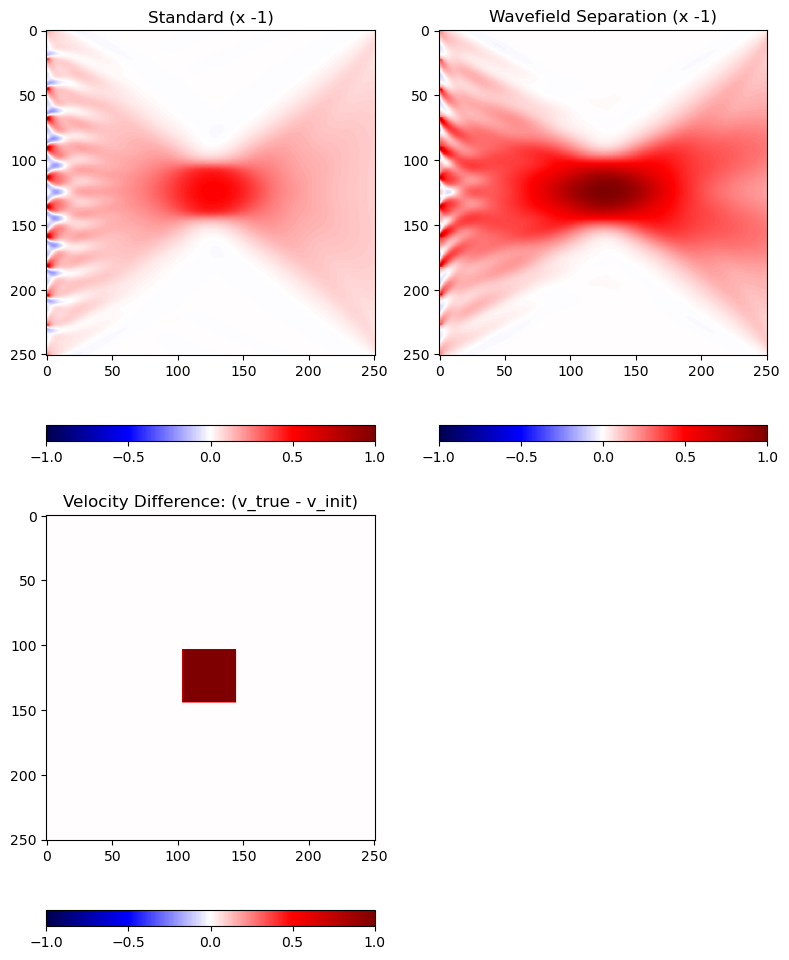

In [18]:
dv = v1 .- v2

figure(figsize=(8,10))

subplot(2,2,1)
imshow(-1 .* grad1 ./ maximum(abs,grad1),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Standard (x -1)");

subplot(2,2,2)
imshow(-1 .* grad2 ./ maximum(abs,grad2),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Wavefield Separation (x -1)");

subplot(2,2,3)
imshow(dv ./ maximum(abs,dv),aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(-1,1);
title("Velocity Difference: (v_true - v_init)");

tight_layout()

#### Build the `cost` function
Note we also need to apply box constraints here to keep the model in the range `[vmin,vmax]`.

In [19]:
function cost(x,F,d1)
    clamp!(x,vmin,vmax)
    dx = F*x
    ϕ = norm(d1 .- dx)
    return ϕ
end

cost (generic function with 1 method)

## 9. Perform the FWI using `Optim.jl`
We will do 10 iterations of limited memory BFGS for each operator. 

In [20]:
niter = 5
tol = 0.001
solver = LBFGS(m = niter, 
    alphaguess = LineSearches.InitialQuadratic(), 
    linesearch = LineSearches.MoreThuente());

In [21]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

#### Optimization with the standard operator

In [22]:
redirect_stdout(open("/dev/null","w")) # otherwise the models are printed to stdout at every iteration

p1 = FwiPar(0,0.0)
f(x) = cost(x,F1,d1)
g!(G,x) = gradient!(G,F1,x,d1,p1)

topt1 = @elapsed begin
    result1 = optimize(f, g!, v2, solver,
        Optim.Options(
            x_tol = tol, f_tol = tol, g_tol = tol,
            iterations = niter, show_trace = true, store_trace = true, show_every = 1,
            extended_trace = true, allow_f_increases = false, callback = mycallback))
end;

┌ Info:   1 g_time;    15.0075 (sec) -- norm(g); 1.0870e+02 -- cost; 7.1038e+02
└ @ Main In[16]:10
┌ Info: iter=0, cost=710.3819, |grad|=47.140747
└ @ Main In[21]:2
┌ Info:   2 g_time;    51.0177 (sec) -- norm(g); 4.9446e+01 -- cost; 3.8617e+02
└ @ Main In[16]:10
┌ Info: iter=1, cost=386.05814, |grad|=12.865246
└ @ Main In[21]:2
┌ Info:   3 g_time;    53.4329 (sec) -- norm(g); 4.6297e+01 -- cost; 3.5992e+02
└ @ Main In[16]:10
┌ Info:   4 g_time;    57.1663 (sec) -- norm(g); 4.2315e+01 -- cost; 2.9490e+02
└ @ Main In[16]:10
┌ Info:   5 g_time;    58.5681 (sec) -- norm(g); 4.2315e+01 -- cost; 2.9490e+02
└ @ Main In[16]:10
┌ Info: iter=2, cost=294.84204, |grad|=14.858142
└ @ Main In[21]:2
┌ Info:   6 g_time;    60.1082 (sec) -- norm(g); 3.6539e+01 -- cost; 2.3827e+02
└ @ Main In[16]:10
┌ Info:   7 g_time;    61.5487 (sec) -- norm(g); 3.6539e+01 -- cost; 2.3827e+02
└ @ Main In[16]:10
┌ Info: iter=3, cost=238.24602, |grad|=13.084422
└ @ Main In[21]:2
┌ Info:   8 g_time;    62.4062 (sec) -- 

In [23]:
@info @printf("Time for optimization (standard); %.2f minutes\n", topt1 / 60)
@info "result1=\n$result1\n"

┌ Info: result1=
│  * Status: failure (reached maximum number of iterations)
│ 
│  * Candidate solution
│     Final objective value:     1.504758e+02
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 8.79e+00 ≰ 1.0e-03
│     |x - x'|/|x'|          = 5.60e-03 ≰ 0.0e+00
│     |f(x) - f(x')|         = 2.04e+01 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 1.35e-01 ≰ 1.0e-03
│     |g(x)|                 = 1.03e+01 ≰ 1.0e-03
│ 
│  * Work counters
│     Seconds run:   769  (vs limit Inf)
│     Iterations:    5
│     f(x) calls:    14
│     ∇f(x) calls:   14
│ 
└ @ Main In[23]:2


#### Optimization with the wavefield separation operator

In [24]:
p2 = FwiPar(0,0.0)
f(x) = cost(x,F2,d1)
g!(G,x) = gradient!(G,F2,x,d1,p2)

topt2 = @elapsed begin
    result2 = optimize(f, g!, v2, solver,
        Optim.Options(
            x_tol = tol, f_tol = tol, g_tol = tol,
            iterations = niter, show_trace = true, store_trace = true, show_every = 1,
            extended_trace = true, allow_f_increases = false, callback = mycallback))
end;

┌ Info:   1 g_time;    28.5834 (sec) -- norm(g); 7.6527e+01 -- cost; 7.1038e+02
└ @ Main In[16]:10
┌ Info: iter=0, cost=710.3819, |grad|=37.78657
└ @ Main In[21]:2
┌ Info:   2 g_time;    71.9665 (sec) -- norm(g); 8.2900e+01 -- cost; 5.6035e+02
└ @ Main In[16]:10
┌ Info:   3 g_time;    72.8678 (sec) -- norm(g); 3.1901e+01 -- cost; 4.2187e+02
└ @ Main In[16]:10
┌ Info:   4 g_time;    73.3078 (sec) -- norm(g); 6.1429e+01 -- cost; 6.0647e+02
└ @ Main In[16]:10
┌ Info:   5 g_time;    73.8390 (sec) -- norm(g); 6.1429e+01 -- cost; 6.0647e+02
└ @ Main In[16]:10
┌ Info: iter=1, cost=606.30054, |grad|=34.140465
└ @ Main In[21]:2
┌ Info:   6 g_time;    73.9328 (sec) -- norm(g); 5.9029e+01 -- cost; 5.8749e+02
└ @ Main In[16]:10
┌ Info:   7 g_time;    71.7344 (sec) -- norm(g); 4.8599e+01 -- cost; 5.1337e+02
└ @ Main In[16]:10
┌ Info:   8 g_time;    72.0062 (sec) -- norm(g); 4.8599e+01 -- cost; 5.1337e+02
└ @ Main In[16]:10
┌ Info: iter=2, cost=513.21735, |grad|=29.268412
└ @ Main In[21]:2
┌ Info:  

In [25]:
@info @printf("Time for optimization (wavefield separation); %.2f minutes\n", topt2 / 60)
@info "result2=\n$result2\n"

┌ Info: result2=
│  * Status: failure (reached maximum number of iterations)
│ 
│  * Candidate solution
│     Final objective value:     2.735316e+02
│ 
│  * Found with
│     Algorithm:     L-BFGS
│ 
│  * Convergence measures
│     |x - x'|               = 9.74e+00 ≰ 1.0e-03
│     |x - x'|/|x'|          = 6.32e-03 ≰ 0.0e+00
│     |f(x) - f(x')|         = 6.07e+01 ≰ 0.0e+00
│     |f(x) - f(x')|/|f(x')| = 2.22e-01 ≰ 1.0e-03
│     |g(x)|                 = 8.73e+00 ≰ 1.0e-03
│ 
│  * Work counters
│     Seconds run:   1161  (vs limit Inf)
│     Iterations:    5
│     f(x) calls:    17
│     ∇f(x) calls:   17
│ 
└ @ Main In[25]:2


In [26]:
vf1 = Optim.minimizer(result1);
vf2 = Optim.minimizer(result2);

clamp!(vf1,vmin,vmax);
clamp!(vf2,vmin,vmax);

ϕ1 = Optim.f_trace(result1);
ϕ2 = Optim.f_trace(result2);

m1 = Optim.x_trace(result1);
m2 = Optim.x_trace(result2);

## 10. Visualize velocity models and objective function

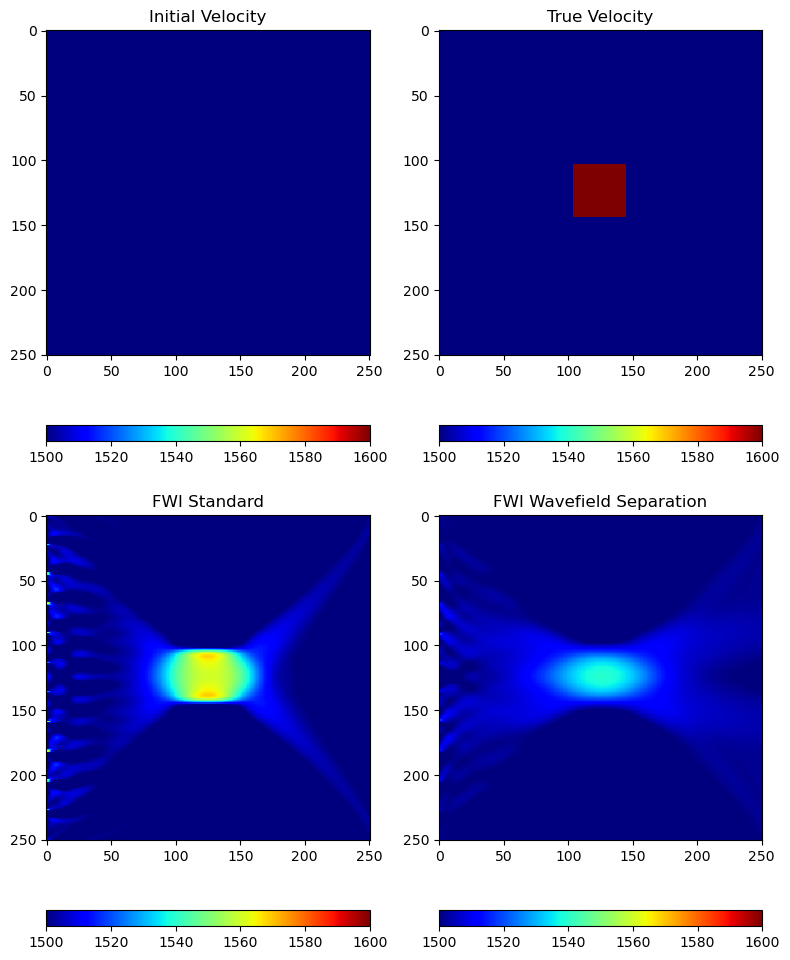

In [27]:
figure(figsize=(8,10)); clf()

subplot(2,2,1);imshow(v2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("Initial Velocity");

subplot(2,2,2);imshow(v1,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("True Velocity")

subplot(2,2,3);imshow(vf1,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("FWI Standard");

subplot(2,2,4);imshow(vf2,aspect="auto",cmap="jet", interpolation="nearest");
colorbar(orientation="horizontal"); clim(vmin,vmax);title("FWI Wavefield Separation");

tight_layout()

#### Display the velocity differences 

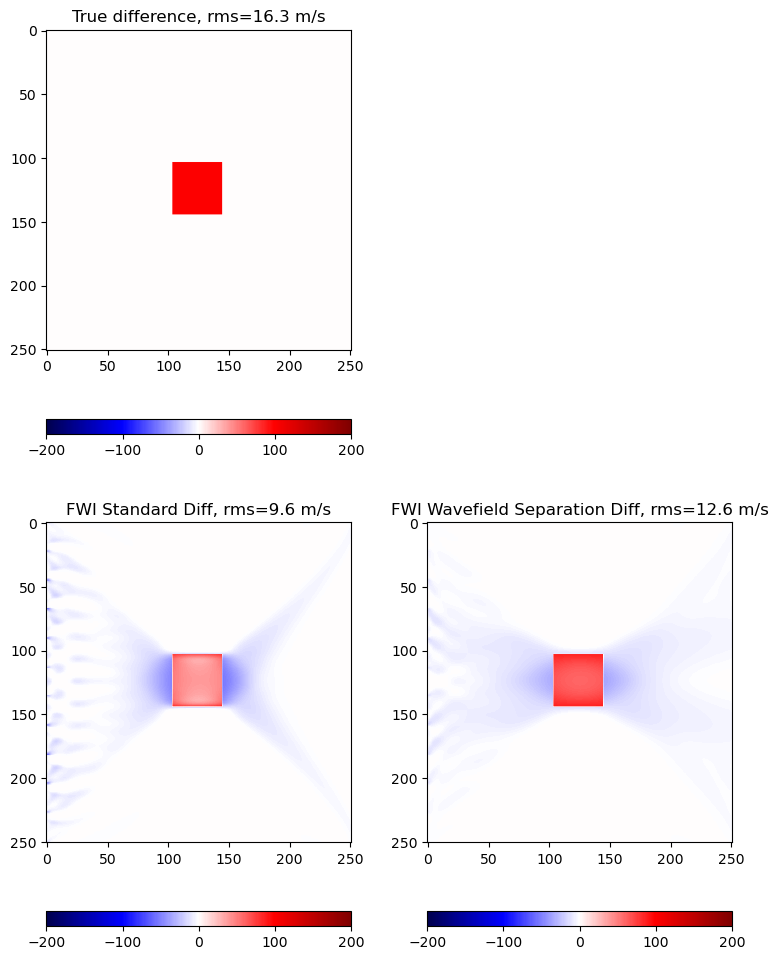

In [28]:
rms_v2  = @sprintf("%.1f m/s", sqrt(norm(v1 .- v2)^2 / length(v1)))
rms_vf1 = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf1)^2 / length(v1)))
rms_vf2 = @sprintf("%.1f m/s", sqrt(norm(v1 .- vf2)^2 / length(v1)))

figure(figsize=(8,10)); clf()

subplot(2,2,1);imshow(v1 .- v2,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("True difference, rms=$(rms_v2)");

subplot(2,2,3);imshow(v1 .- vf1,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("FWI Standard Diff, rms=$(rms_vf1)");

subplot(2,2,4);imshow(v1 .- vf2,aspect="auto",cmap="seismic");
colorbar(orientation="horizontal");clim(dmin,dmax);
title("FWI Wavefield Separation Diff, rms=$(rms_vf2)");

tight_layout()

#### Display the cost function 

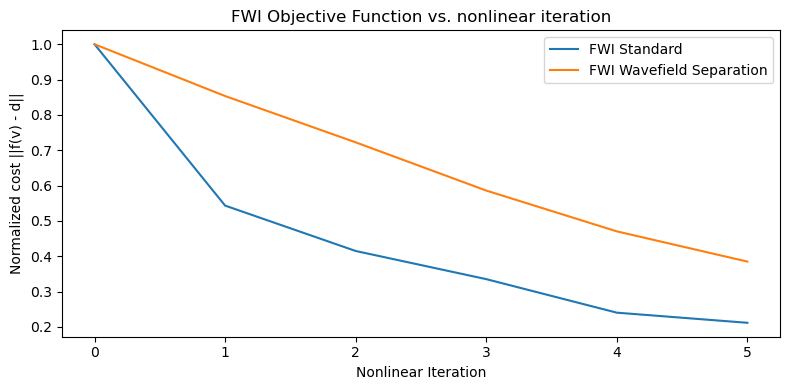

0.3850487f0

In [29]:
figure(figsize=(8,4)); clf()
iters = [0:1:niter;]
plot(iters, ϕ1 ./ ϕ2[1], label="FWI Standard")
plot(iters, ϕ2 ./ ϕ2[1], label="FWI Wavefield Separation")
legend()
xlabel("Nonlinear Iteration")
ylabel("Normalized cost ||f(v) - d||")
title("FWI Objective Function vs. nonlinear iteration");
tight_layout()

@show ϕ1[end] / ϕ1[1]
@show ϕ2[end] / ϕ2[1]

#### Display Pareto curves

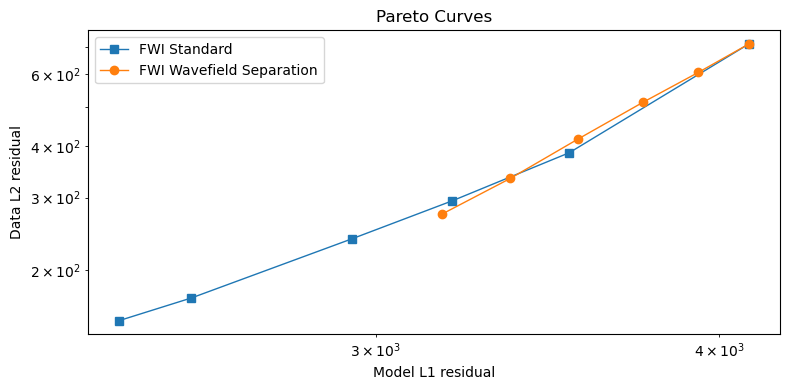

In [40]:
figure(figsize=(8,4)); clf()

c1 = [norm(m1[i] .- v1,2) for i in 1:length(m1)]
c2 = [norm(m2[i] .- v1,2) for i in 1:length(m1)]

@show c1

loglog(c1, ϕ1, label="FWI Standard", marker="s", linewidth=1)
loglog(c2, ϕ2, label="FWI Wavefield Separation", marker="o", linewidth=1)
legend()
xlabel("Model L1 residual")
ylabel("Data L2 residual")
title("Pareto Curves");
tight_layout()

## 11. Visualize data match
#### Generate data in the FWI velocity models

In [31]:
tf1 = @elapsed begin
    df1 = F1*vf1;
end
@show tf1;

tf2 = @elapsed begin
    df2 = F1*vf2;
end
@show tf2;

#### Compute residuals and collect gathers for display

In [32]:
rf1 = d1 .- df1;
rf2 = d1 .- df2;

df1local = [getblock(df1,i) for i in shots];
df2local = [getblock(df2,i) for i in shots];
rf1local = [getblock(rf1,i) for i in shots];
rf2local = [getblock(rf2,i) for i in shots];

#### Plot shot gathers for true, initial model, and fwi models

The table below describes the data images below. We include the initial data as shown above for easier comparison. 

<table style="border:1px solid black;" width="60%">
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>Initial Residual</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Standard</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Standard Residual</b></td>
</tr>
<tr>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>True</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Wavefield Separation</b></td>
  <td style="border:1px solid black; text-align:center;" bgcolor="white">
      <b>FWI Wavefield Separation Residual</b></td>
</tr>
</table>

We first make a function to create the plots that we can re-use for the selected shots.

In [39]:
function make_plot(index)
    figure(figsize=(8,9)); clf()
    catii = hcat(d1local[index],  pad, d2local[index],  pad, r1local[index])
    catf1 = hcat(df1local[index], pad, df1local[index], pad, rf1local[index])
    catf2 = hcat(df2local[index], pad, df2local[index], pad, rf2local[index])

    subplot(3,1,1);
    imshow(catii,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sx=$(sx[index])   |   Initial sx=$(sx[index])   |   Initial Residual sx=$(sx[index])");
    
    subplot(3,1,2);
    imshow(catf1,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sx=$(sx[index])   |   FWI Standard sx=$(sx[index])   |   Initial Residual sx=$(sx[index])");
    
    subplot(3,1,2);
    imshow(catf2,cmap="gray",aspect="auto",clim=[-1,+1]);
    title("True sx=$(sx[index])   |   FWI Wavefield Separation sx=$(sx[index])   |   Initial Residual sx=$(sx[index])");
    
    tight_layout()
end

make_plot (generic function with 1 method)

#### Data for the 1st shot, generated in the initial and FWI models

In [34]:
make_plot(1)

LoadError: UndefVarError: r1local not defined

#### Data for the 4th shot, generated in the initial and FWI models

In [35]:
make_plot(2)

LoadError: UndefVarError: r1local not defined

#### Data for the 8th shot, generated in the initial and FWI models

In [36]:
make_plot(3)

LoadError: UndefVarError: r1local not defined

## 12. Remove local files and workers

In [37]:
# close(F);
# rmprocs(workers());

## Record time at end of notebook
Report total elapsed time to run the notebook

In [38]:
time_end = time()
@sprintf("Time to run notebook; %.2f minutes\n", (time_end - time_beg) / 60)

"Time to run notebook; 37.29 minutes\n"